In [ ]:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aretiz/DAMSL-373/blob/main/tutorial_GANs.ipynb)

# **Implementing basic Generative Adversarial Networks (GANs)**

Lets Generate Some Animals with GANs!  🦜🦓🦒🐅

---






In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### **Deep Convolutional Generative Adversarial Network (DCGAN)**

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*cCa0FX-yXOPJ86bUkwCEAA.png)


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential( # A container that stacks layers sequentially.
            nn.ConvTranspose2d(latent_size, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)


In [5]:
# Data preprocessing
image_size = 32
batch_size = 128

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR-10 dataset (only animals)
cifar10_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
animal_classes = [2, 3, 4, 5, 6, 7] # Bird, Cat, Deer, Dog, Frog, Horse

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_data = [(img, label) for img, label in trainset if label in animal_classes]
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

100%|██████████| 170M/170M [00:05<00:00, 30.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


### **Visualize some of the training data**

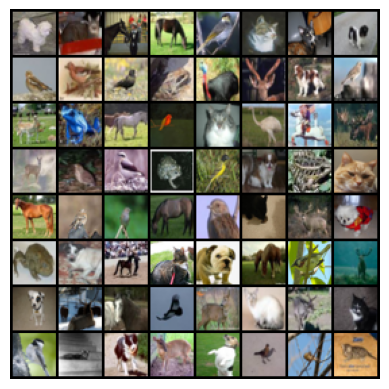

In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Create a grid of images
img_grid = vutils.make_grid(images[:64], normalize=True)

# Plot the images
plt.imshow(np.transpose(img_grid.numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

### **Training the DCGAN model**

Starting Training Loop...
[0/2][0/235]	Loss_D: 1.4436	Loss_G: 3.2618	D(x): 0.4645	D(G(z)): 0.4791 / 0.0403
[0/2][50/235]	Loss_D: 0.0876	Loss_G: 15.0849	D(x): 0.9218	D(G(z)): 0.0000 / 0.0000
[0/2][100/235]	Loss_D: 0.0498	Loss_G: 9.2280	D(x): 0.9540	D(G(z)): 0.0002 / 0.0001
[0/2][150/235]	Loss_D: 0.2285	Loss_G: 5.1613	D(x): 0.9831	D(G(z)): 0.1651 / 0.0169
[0/2][200/235]	Loss_D: 0.6227	Loss_G: 3.7913	D(x): 0.6219	D(G(z)): 0.0196 / 0.0400
[1/2][0/235]	Loss_D: 0.9074	Loss_G: 3.8378	D(x): 0.7725	D(G(z)): 0.4160 / 0.0296
[1/2][50/235]	Loss_D: 0.7787	Loss_G: 2.6341	D(x): 0.6700	D(G(z)): 0.2320 / 0.0918
[1/2][100/235]	Loss_D: 1.0838	Loss_G: 1.7371	D(x): 0.4698	D(G(z)): 0.0583 / 0.2363
[1/2][150/235]	Loss_D: 0.5153	Loss_G: 2.6067	D(x): 0.7323	D(G(z)): 0.1446 / 0.0949
[1/2][200/235]	Loss_D: 0.6814	Loss_G: 4.6459	D(x): 0.9041	D(G(z)): 0.3925 / 0.0133


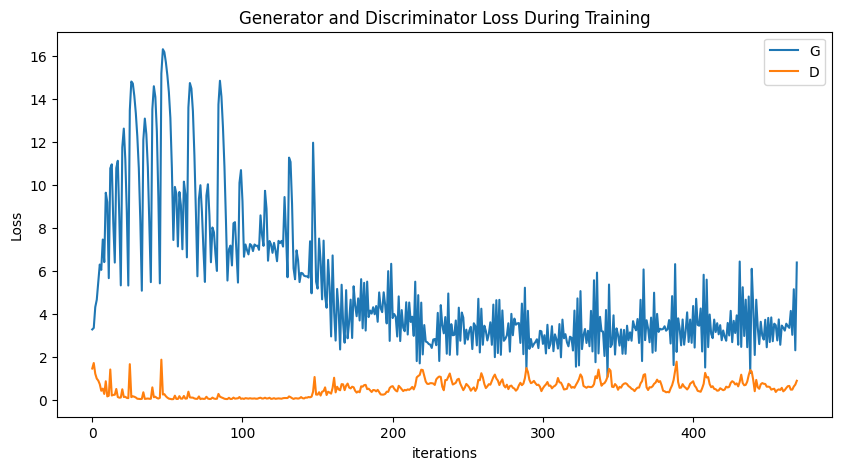

In [ ]:
# Hyperparameters
latent_size = 100
num_epochs = 2#50
learning_rate = 0.0002
beta1 = 0.5

# Initialize Generator and Discriminator
netG = Generator().to(device)
netD = Discriminator().to(device)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))

# Fixed noise vector for visualization
fixed_noise = torch.randn(64, latent_size, 1, 1, device=device)

# Training loop
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(trainloader, 0):
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        # Train with real images
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), 1, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Train with fake images
        noise = torch.randn(b_size, latent_size, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(0)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # (2) Update G network: maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(1)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(trainloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(trainloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

# Plot the loss
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Lets generate some images now!

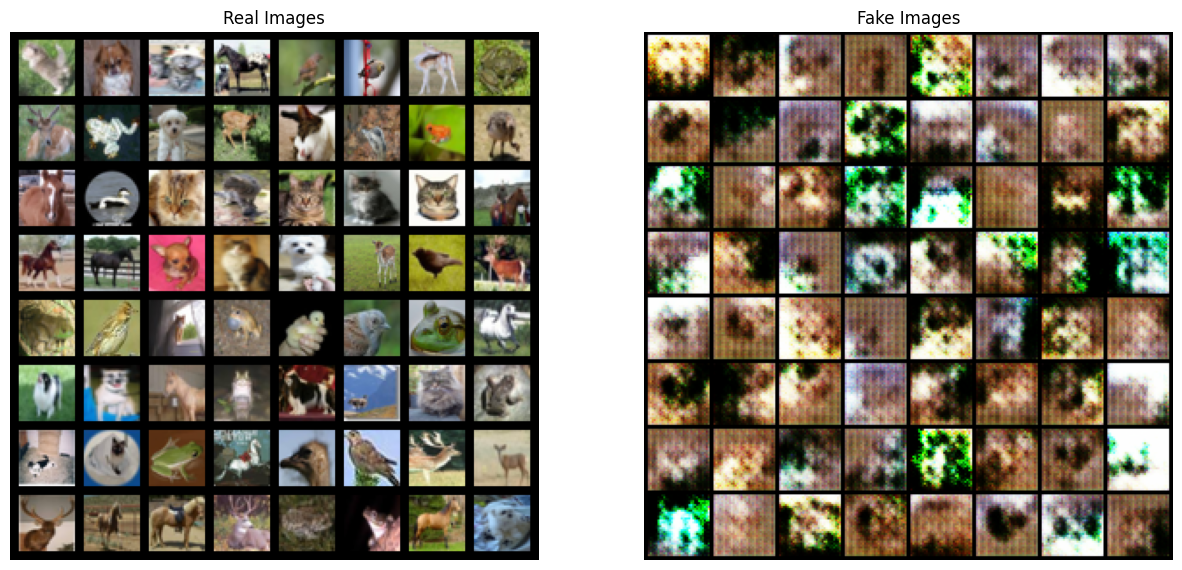

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(trainloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

### **What about evaluation?**

- **Inception Score (IS)**
  - Measures how diverse and realistic the generated images are.
  - Higher IS indicates more diverse and realistic images.

- **Fréchet Inception Distance (FID) [link text]**
  - Measures how similar the generated images are to real images.
  - Lower FID means better quality and diversity.

  

| Metric | Measures | Lower is Better? | Higher is Better? |
|--------|----------|------------------|------------------|
| **FID** (Fréchet Inception Distance) | Realism & Diversity (compared to real images) | ✅ | ❌ |
| **IS** (Inception Score) |  Realism & Diversity (without real images) | ❌ | ✅ |

In [ ]:
# Define a transform to resize images to 75x75
resize_transform = transforms.Compose([
    transforms.Resize((75, 75)),  # Resize images
    transforms.ToTensor()
])

def calculate_fid(real_imgs, fake_imgs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inception_model = models.inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.eval()

    def get_features(imgs):
        imgs = F.interpolate(imgs, size=(75, 75), mode='bilinear', align_corners=False)  # Resize dynamically
        with torch.no_grad():
            features = inception_model(imgs).cpu().numpy()
        return np.mean(features, axis=0), np.cov(features, rowvar=False)

    mu_r, sigma_r = get_features(real_imgs.to(device))
    mu_g, sigma_g = get_features(fake_imgs.to(device))

    fid = np.sum((mu_r - mu_g) ** 2) + np.trace(sigma_r + sigma_g - 2 * sqrtm(sigma_r @ sigma_g))
    return fid.real  # Remove small imaginary part

def calculate_inception_score(fake_imgs, splits=10):
    """
    Compute the Inception Score (IS) for a batch of generated images.

    Parameters:
    - fake_imgs: Tensor of generated images (B, C, H, W)
    - splits: Number of splits for stability (default=10)

    Returns:
    - mean IS score, standard deviation
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inception_model = models.inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.eval()

    with torch.no_grad():
        # Resize images for InceptionV3 input
        fake_imgs = F.interpolate(fake_imgs, size=(75, 75), mode='bilinear', align_corners=False)
        preds = F.softmax(inception_model(fake_imgs), dim=1).cpu().numpy()

    # Compute IS for each split
    split_scores = []
    N = preds.shape[0]
    split_size = N // splits

    for k in range(splits):
        part = preds[k * split_size: (k + 1) * split_size]
        p_y = np.mean(part, axis=0)  # Mean probability distribution
        kl_div = part * (np.log(part) - np.log(p_y))
        split_scores.append(np.exp(np.mean(np.sum(kl_div, axis=1))))  # Compute exp of KL divergence

    return np.mean(split_scores), np.std(split_scores)  # Return mean and std deviation

# IS
fake_images = netG(fixed_noise).detach()

is_mean, is_std = calculate_inception_score(fake_images)
print(f'Inception Score: {is_mean:.4f} ± {is_std:.4f}')

# FID
real_images = real_batch[0].to(device)
fake_images = netG(fixed_noise).detach()

fid_score = calculate_fid(real_images, fake_images)
print(f'FID Score: {fid_score:.4f}')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 166MB/s] 


Inception Score: 1.0596 ± 0.0154
FID Score: 559.2806


### **How to Interpret IS and FID Scores?**  
- **FID < 10** → **Excellent** (Close to real images, high quality & diversity)  
- **10 ≤ FID < 50** → **Good** (Reasonable quality, minor flaws)  
- **50 ≤ FID < 100** → **Average** (Visible artifacts, some mode collapse)  
- **100 ≤ FID < 300** → **Poor** (Major quality issues, lacks diversity)  
- **FID > 300** → **Very bad** (Generated images are far from realistic)  

### **Interpreting Inception Score (IS)**

- **IS ≈ 1-3** → Poor (low diversity, unrealistic images)  
- **IS ≈ 5-8** → Decent (somewhat realistic images with diversity)  
- **IS > 8** → Good (high quality, diverse images)  
- **Real-world images** (e.g., CIFAR-10) typically score **~11**  





### **A Smoother Path to Perfect Animals: DCGAN with Wasserstein Distance & Gradient Penalty**

Use the Wasserstein loss (Wasserstein distance) for more stable and improved learning.

In [8]:
# Generator Model (same as before)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Discriminator Model with no sigmoid (for Wasserstein)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False)
        )

    def forward(self, input):
        return self.main(input)

# Wasserstein Loss & Gradient Penalty Function

# Wasserstein Loss
def wasserstein_loss(y_real, y_fake):
    return torch.mean(y_real) - torch.mean(y_fake)


def compute_gradient_penalty(D, real_samples, fake_samples):
    batch_size = real_samples.size(0)  # This assumes both tensors have the same batch size
    # Random weight term for interpolation
    alpha = torch.rand(batch_size, 1, 1, 1).to(device)

    # Ensure both real and fake have the same batch size
    assert real_samples.size(0) == fake_samples.size(0), f"Batch size mismatch: real_samples: {real_samples.size(0)}, fake_samples: {fake_samples.size(0)}"

    # Create interpolated samples
    interpolated_samples = alpha * real_samples + (1 - alpha) * fake_samples

    # Set requires_grad=True for the interpolated samples
    interpolated_samples.requires_grad_()

    # Compute the output of the discriminator for the interpolated samples
    d_interpolated = D(interpolated_samples)

    # Compute the gradients w.r.t. the interpolated samples
    gradients = torch.autograd.grad(outputs=d_interpolated, inputs=interpolated_samples,
                                   grad_outputs=torch.ones_like(d_interpolated),
                                   create_graph=True, retain_graph=True, only_inputs=True)[0]

    # Compute the gradient penalty
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    return gradient_penalty


### **Training Loop with Gradient Penalty**

[1/2][0/235]	Loss_D: 1.1638	Loss_G: 4.0701
[1/2][50/235]	Loss_D: -139.0659	Loss_G: 71.3679
[1/2][100/235]	Loss_D: -249.6017	Loss_G: 126.7094
[1/2][150/235]	Loss_D: -362.8777	Loss_G: 183.3140
[1/2][200/235]	Loss_D: -479.4243	Loss_G: 241.7371
[2/2][0/235]	Loss_D: -562.9109	Loss_G: 283.8244
[2/2][50/235]	Loss_D: -687.7755	Loss_G: 345.9829
[2/2][100/235]	Loss_D: -806.1949	Loss_G: 406.4189
[2/2][150/235]	Loss_D: -944.9631	Loss_G: 474.8250
[2/2][200/235]	Loss_D: -1084.0232	Loss_G: 544.3092


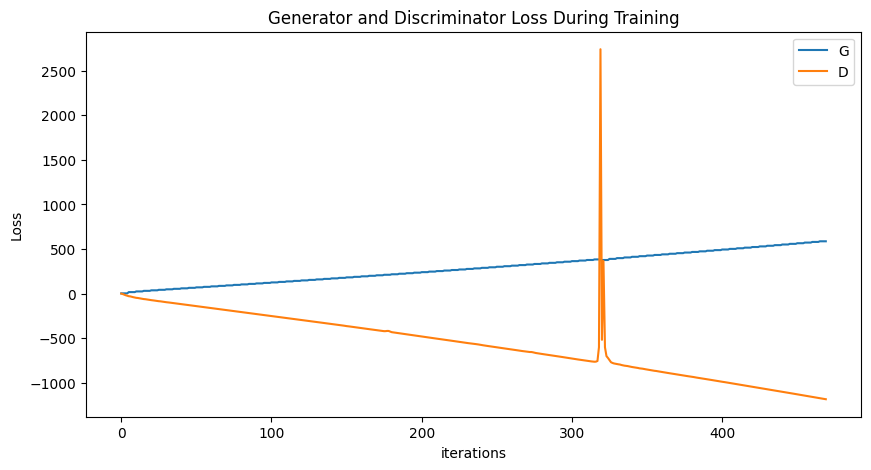

In [9]:
# Hyperparameters
latent_size = 100
batch_size = 128
num_epochs = 2#50
learning_rate = 0.0002
beta1 = 0.5

# Initialize Generator and Discriminator
netG = Generator().to(device)
netD = Discriminator().to(device)

# Optimizers (same as before)
optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))

# Fixed noise for generating images
fixed_noise = torch.randn(64, latent_size, 1, 1, device=device)

img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(num_epochs):
    for i, data in enumerate(trainloader, 0):
        # (1) Update D network: Maximize W(D(x)) - W(D(G(z)))
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), 1, dtype=torch.float, device=device)

        # Train with real images
        output = netD(real_cpu).view(-1)
        errD_real = wasserstein_loss(output, label)
        errD_real.backward()

        # Train with fake images
        noise = torch.randn(b_size, latent_size, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(-1)  # Label for fake images is -1 in WGAN
        output = netD(fake.detach()).view(-1)
        errD_fake = wasserstein_loss(output, label)
        errD_fake.backward()

        # Gradient Penalty
        gradient_penalty = compute_gradient_penalty(netD, real_cpu, fake)
        gradient_penalty.backward(retain_graph=True)

        # Update Discriminator
        errD = errD_real + errD_fake + 10 * gradient_penalty
        optimizerD.step()

        # (2) Update G network: Maximize W(D(G(z)))
        if i % 5 == 0:  # Update the generator less frequently
            netG.zero_grad()
            label.fill_(1)  # Label for real images is 1 in WGAN
            output = netD(fake).view(-1)
            errG = -torch.mean(output)
            errG.backward()
            optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch+1, num_epochs, i, len(trainloader), errD.item(), errG.item()))

        # Save losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(trainloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

# Plot the losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### **Generate some Images**

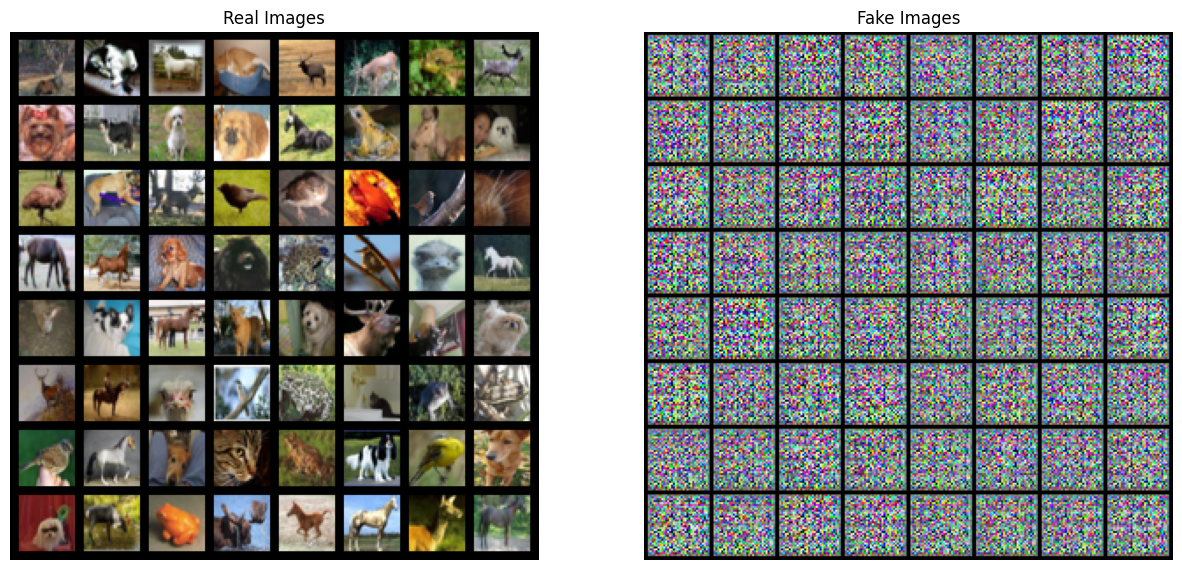

In [10]:
# Grab a batch of real images
real_batch = next(iter(trainloader))

# Plot real vs fake images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

### **Evaluation**

In [ ]:
# IS
fake_images = netG(fixed_noise).detach()

is_mean, is_std = calculate_inception_score(fake_images)
print(f'Inception Score: {is_mean:.4f} ± {is_std:.4f}')

# FID
real_images = real_batch[0].to(device)
fake_images = netG(fixed_noise).detach()

fid_score = calculate_fid(real_images, fake_images)
print(f'FID Score: {fid_score:.4f}')

Inception Score: 1.0589 ± 0.0699
FID Score: 478.4650


### **Conditional Generative Adversarial Network (cGAN)**

In [ ]:
class Generator(nn.Module):
    def __init__(self, num_classes=6):  # 6 animal classes
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)

        self.latent_size = 100
        self.label_size = num_classes

        # Initial dense layer to combine noise and class embedding
        self.dense = nn.Linear(self.latent_size + self.label_size, 512 * 4 * 4)

        self.main = nn.Sequential(
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Embed labels
        label_embedding = self.label_embedding(labels)
        # Concatenate noise and label embedding
        x = torch.cat([noise.squeeze(), label_embedding], 1)
        # Dense layer
        x = self.dense(x)
        # Reshape for convolutional layers
        x = x.view(-1, 512, 4, 4)
        # Pass through main convolutional layers
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self, num_classes=6):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)

        # Process image
        self.conv = nn.Sequential(
            nn.Conv2d(3, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Final layers combining conv features and label embedding
        self.final = nn.Sequential(
            nn.Linear(512 * 4 * 4 + num_classes, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        # Process image through conv layers
        x = self.conv(x)
        x = x.view(-1, 512 * 4 * 4)

        # Get label embedding
        label_embedding = self.label_embedding(labels)

        # Concatenate flattened conv output with label embedding
        x = torch.cat([x, label_embedding], 1)

        # Final classification
        return self.final(x)

Files already downloaded and verified
Starting Training Loop...
[0/50][0/235] Loss_D: 1.3916 Loss_G: 2.7511
[0/50][50/235] Loss_D: 0.0085 Loss_G: 10.3741
[0/50][100/235] Loss_D: 0.0226 Loss_G: 15.6074
[0/50][150/235] Loss_D: 0.5157 Loss_G: 11.7816
[0/50][200/235] Loss_D: 0.4726 Loss_G: 5.3732
[1/50][0/235] Loss_D: 0.2051 Loss_G: 4.2016
[1/50][50/235] Loss_D: 1.2450 Loss_G: 3.4900
[1/50][100/235] Loss_D: 0.4318 Loss_G: 4.3760
[1/50][150/235] Loss_D: 0.1543 Loss_G: 4.3475
[1/50][200/235] Loss_D: 0.6131 Loss_G: 3.3522
[2/50][0/235] Loss_D: 0.2671 Loss_G: 4.4038
[2/50][50/235] Loss_D: 0.7079 Loss_G: 3.1184
[2/50][100/235] Loss_D: 0.4076 Loss_G: 4.1394
[2/50][150/235] Loss_D: 0.4118 Loss_G: 3.6889
[2/50][200/235] Loss_D: 0.2103 Loss_G: 2.5092
[3/50][0/235] Loss_D: 0.2108 Loss_G: 3.5734
[3/50][50/235] Loss_D: 0.7828 Loss_G: 9.0488
[3/50][100/235] Loss_D: 0.2165 Loss_G: 4.3121
[3/50][150/235] Loss_D: 0.1995 Loss_G: 5.0407
[3/50][200/235] Loss_D: 0.0371 Loss_G: 3.6252
[4/50][0/235] Loss_D: 0.1

KeyboardInterrupt: 

In [ ]:
# Hyperparameters
latent_size = 100
batch_size = 128
image_size = 32
num_epochs = 50
learning_rate = 0.0002
beta1 = 0.5
num_classes = 6  # Number of animal classes

# Data preprocessing
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR-10 dataset (only animals)
cifar10_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
animal_classes = [2, 3, 4, 5, 6, 7]  # Bird, Cat, Deer, Dog, Frog, Horse

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_data = [(img, animal_classes.index(label)) for img, label in trainset if label in animal_classes]
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [ ]:
# Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netG = Generator(num_classes=num_classes).to(device)
netD = Discriminator(num_classes=num_classes).to(device)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))

# Training loop
print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, (data, labels) in enumerate(trainloader):
        batch_size = data.size(0)
        real_labels = torch.ones(batch_size, device=device)
        fake_labels = torch.zeros(batch_size, device=device)

        # Update Discriminator
        netD.zero_grad()
        real_images = data.to(device)
        labels = labels.to(device)

        # Train with real images
        output = netD(real_images, labels).view(-1)
        errD_real = criterion(output, real_labels)
        errD_real.backward()

        # Train with fake images
        noise = torch.randn(batch_size, latent_size, 1, 1, device=device)
        # Generate random labels for fake images
        fake_class_labels = torch.randint(0, num_classes, (batch_size,), device=device)
        fake_images = netG(noise, fake_class_labels)
        output = netD(fake_images.detach(), fake_class_labels).view(-1)
        errD_fake = criterion(output, fake_labels)
        errD_fake.backward()

        errD = errD_real + errD_fake
        optimizerD.step()

        # Update Generator
        netG.zero_grad()
        output = netD(fake_images, fake_class_labels).view(-1)
        errG = criterion(output, real_labels)
        errG.backward()
        optimizerG.step()

        if i % 50 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(trainloader)}] '
                  f'Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f}')



In [ ]:
# Function to generate images of specific classes
def generate_class_samples(netG, num_samples, class_label, device):
    with torch.no_grad():
        noise = torch.randn(num_samples, latent_size, 1, 1, device=device)
        labels = torch.full((num_samples,), class_label, device=device)
        fake = netG(noise, labels)
        return fake

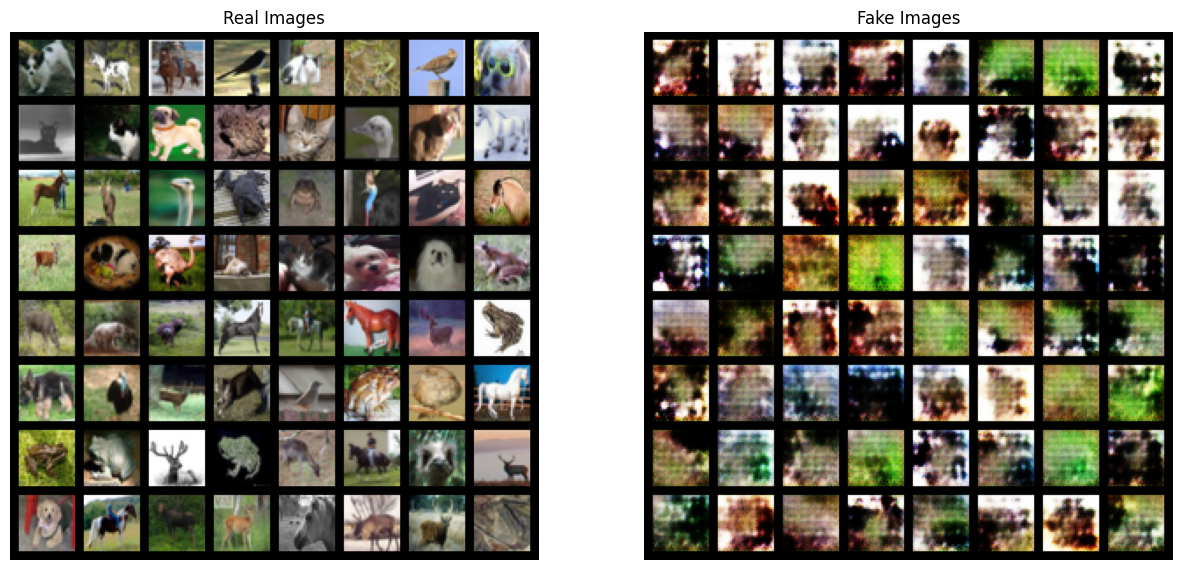

In [ ]:
# Plot real images
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(), (1, 2, 0)))

# Generate fake images
fake_images = generate_class_samples(netG, num_samples=64, class_label=3, device=torch.device("cuda"))

# Move images to CPU and convert to numpy
fake_images = fake_images.cpu().numpy()

# Plot fake images in a grid
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")


fake_images = np.transpose(fake_images, (0, 2, 3, 1))

# Create a grid of fake images
plt.imshow(np.transpose(vutils.make_grid(torch.tensor(fake_images).permute(0, 3, 1, 2), padding=5, normalize=True).cpu(), (1, 2, 0)))

plt.show()
